In [1]:
from pymongo import MongoClient
import pandas as pd
# from dotenv import load_dotenv

# load_dotenv(verbose=True,dotenv_path='./env')

# mongoDB 설정
mongo_host = "localhost"
mongo_port = 27020
mongo_user = "churros"
mongo_passwd = "A503"
mongo_db_name = "newsdb"
mongo_client = MongoClient(host=mongo_host, port=mongo_port, username=mongo_user, password=mongo_passwd)


db = mongo_client[mongo_db_name]
collection = db['newsCol']
tokencollection = db['newsToken'] # token collection

In [2]:
data = list(collection.find())
df = pd.DataFrame(data)

## Quality Measurement
- 제목길이, 본문길이, 기자 정보(skip), 섹션 정보, 콘텐츠 타입 정보(skip), 이미지 여부 -> feature로 활용
- 추가적인 feature를 생성해도 될듯 (단어 갯수, 기타 등등...)
- 위의 features 활용하여 기사의 quality 측정
- 우선은 다중 회귀 활용 예정

In [16]:
df_raw = pd.DataFrame(data)
df = df_raw
# 제목 길이 변수
df['title_len'] = df['title'].apply(len)
# 본문 길이 변수
df['full_text'] = df['full_text'].apply(str)
df['full_text_len'] = df['full_text'].apply(len)
# 언론사 정보???
# 카테고리 정보 (one hot encoding)
category_dummies = pd.get_dummies(df['cat1'])
df = pd.concat([df, category_dummies], axis=1)
category_dummies2 = pd.get_dummies(df['cat2'])
df = pd.concat([df, category_dummies2], axis=1)
# 콘텐츠 타입 정보? pass

# 이미지 여부(boolean)
df['img'] = df['img_src'].apply(lambda x: 1 if x != "" else 0)
df_quality = df.iloc[:,12:]
x = df_quality.iloc[:,:-1]
# 값의 경우 labeling 이 진행되어야 한다
## quality 만들어주는 함수
def get_quality(row):
    if len(row['full_text']) < 50 or (len(row['full_text']) > 50 and len(row['full_text']) < 200 and not row['img_src']):
        return 0
    else:
        return 1

df['quality'] = df.apply(get_quality, axis=1)
y = df['quality']
print(df_quality.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128607 entries, 0 to 128606
Data columns (total 44 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   full_text_len  128607 non-null  int64
 1   IT/과학          128607 non-null  uint8
 2   경제             128607 non-null  uint8
 3   사회             128607 non-null  uint8
 4   생활/문화          128607 non-null  uint8
 5   연예             128607 non-null  uint8
 6   정치             128607 non-null  uint8
 7   IT 일반          128607 non-null  uint8
 8   게임/리뷰          128607 non-null  uint8
 9   경제 일반          128607 non-null  uint8
 10  과학 일반          128607 non-null  uint8
 11  교육             128607 non-null  uint8
 12  국방/외교          128607 non-null  uint8
 13  국회/정당          128607 non-null  uint8
 14  글로벌 경제         128607 non-null  uint8
 15  금융             128607 non-null  uint8
 16  노동             128607 non-null  uint8
 17  대통령실           128607 non-null  uint8
 18  드라마            128607 no

In [28]:
# 다중 회귀 분석
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3)
mlr = LinearRegression()
mlr.fit(x_train, y_train)
print(mlr.score(x_train, y_train))
# 이제 mlr.predict(features) 에 값을 넣으면 결과값이 나온다
# 이 결과값을 기준으로 특정 점수 이하일 경우 분석에서 제외 또는 출력에서 제외

0.0964205184232354


In [29]:
y_predict = mlr.predict(x_test)
y_predict

array([0.96931833, 0.97882107, 0.96336841, ..., 1.00268594, 0.97981506,
       0.95916184])

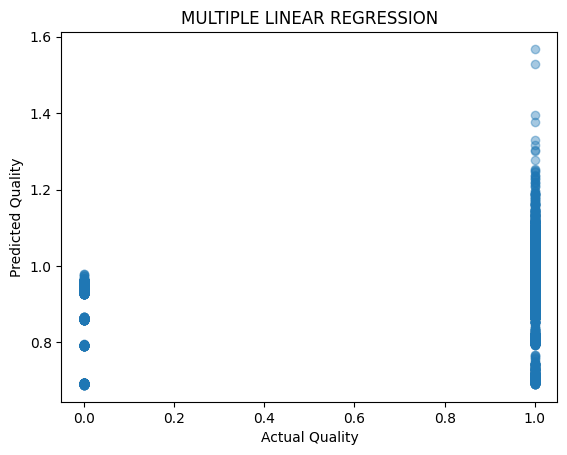

In [30]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()